In [80]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append('..')
sys.path.append('../src')
import os
from os.path import join as oj
import numpy as np
from copy import deepcopy
import pandas as pd
import data
# import models
from math import ceil
# from style import *
import dvu
import pickle as pkl
# from style import *
import viz
from viz import *
import config
outcome_def = 'y_consec_thresh'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# df = data.get_data(use_processed=True) #, dset='orig') # all_data=True
df = data.get_data(dset='clath_aux_dynamin')
dfv = df[~(df.short | df.long | df.hotspots)]
dfv = dfv[dfv.lifetime > 15] # only keep hard tracks
# dfv = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots

In [3]:
dft = dfv[dfv.cell_num.isin(config.DSETS['clath_aux_dynamin']['test'])] # exclude held-out test data

**plot curves (for intro fig)**

In [ ]:
R, C = 2, 2
plt.figure(facecolor='w', figsize=(5, 5))
viz.plot_curves(dfv.iloc[[0, 1, 48, 37]], extra_key='Z', extra_key_label='Dynamin',
                R=R, C=R, fig=True, ylim_constant=True, legend=False, hline=False)
plt.subplot(R, C, 2)
plt.legend(fontsize=20, frameon=False, handlelength=0.7)
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.xlim((0, 60))
viz.savefig('intro_curves')

**plot curves (for examples fig)**

In [ ]:
plt.figure(figsize=(3, 8))
R, C = 3, 1
dfv_minus = dfv[dfv[outcome_def] == 0].sort_values('X_max')
viz.plot_curves(dfv_minus, R=R, C=C, fig=True, extra_key='Z',
                ylim_constant=True, legend=False, hline=False)
plt.xlabel('Time (frames)')
plt.ylabel('Amplitude')
plt.subplot(R, C, 1)
# plt.legend(fontsize=18)
r = dfv_minus.iloc[0]
plt.text(len(r.X), r.X[-1], 'Clathrin', color=cr, fontsize=20)
# plt.title('A', loc='left', fontweight='bold')
plt.text(len(r.Z), 50, 'Dynamin', color='gray', fontsize=20)
plt.text(len(r.Y), 0, 'Auxilin', color=cg, fontsize=20)
plt.title('Abortive')
plt.tight_layout()
viz.savefig('traces_minus')
# plt.savefig('figs/fig_traces_minus.pdf')

plt.figure(figsize=(3, 8))
dfv_plus = dfv[(dfv[outcome_def] == 1) & (dfv.lifetime < 50)].sort_values('Y_max', ascending=False)
viz.plot_curves(dfv_plus, R=R, C=C, fig=True, extra_key='Z',
                ylim_constant=True, legend=False, hline=False)
plt.xlabel('Time (frames)')
plt.ylabel('Amplitude')
plt.subplot(R, C, 1)
# plt.title('B', loc='left', fontweight='bold')
plt.title('Valid')
plt.tight_layout()
viz.savefig('traces_plus')
# plt.savefig('figs/fig_traces_plus.pdf')

## extract and plot videos

In [71]:
event_type = 'valid'
dfv = {'abortive': dfv_minus, 'valid': dfv_plus}
videos = viz.get_dynamin_data_videos(dfv[event_type], dfv[event_type].pid.values[:3])

In [ ]:
pid = dfv[event_type].pid.values[2]
n = len(videos[pid]['aux'])

fig = plt.figure(figsize=(9, 6), dpi=200)
cmaps = {'cla': 'Reds', 'aux': 'Greens', 'dyn': 'Greys'}
for k, m in enumerate(['cla', 'aux', 'dyn']):
    for i in range(len(videos[pid][m])):
        ax = plt.subplot(6, 9, i + 1 + k*18)
        ax.imshow(videos[pid][m][i], vmin=0, vmax=1, cmap=cmaps[m]) # Auxilin
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(label=f't={i + 1}', fontsize=8)

fig.text(0, 0.83, 'Clathrin trace', va='center', rotation='vertical')
fig.text(0, 0.5, 'Auxilin trace', va='center', rotation='vertical')
fig.text(0, 0.17, 'Dynamin trace', va='center', rotation='vertical')
plt.tight_layout()

viz.savefig(f'{event_type}_example')

## make grid version of figs¶

### grid of curves

In [ ]:
d = pd.DataFrame()
for l in [12, 21, 39]:
    ds = df[df.lifetime == l].sort_values('X_max')
    d = d.append(ds.iloc[[0, ds.shape[0]//2, -1]])

# print(d)
fig = plt.figure(figsize=(10, 9))
viz.plot_curves(d, R=3, C=3, hline=False,
                xlim_constant=True,
                ylim_constant=True,
                legend=False,
                extra_key='Z',
                extra_key_label='Dynamin',
                xlim=(0, 40),
                ylim=(-300, 40000),
                fig=fig)
plt.subplot(3, 3, 3)
dvu.line_legend()
plt.xlim((0, 40))

plt.subplot(3, 3, 4)
plt.ylabel('Fitted amplitude')

plt.subplot(3, 3, 8)
plt.xlabel('Lifetime')


viz.savefig('intro_grid')
plt.show()

In [78]:
videos = viz.get_dynamin_data_videos(d, d.pid.values)

<ipython-input-83-7f81976171f5>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, nsub, 1)
<ipython-input-83-7f81976171f5>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, nsub, nsub + 1)
<ipython-input-83-7f81976171f5>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always 

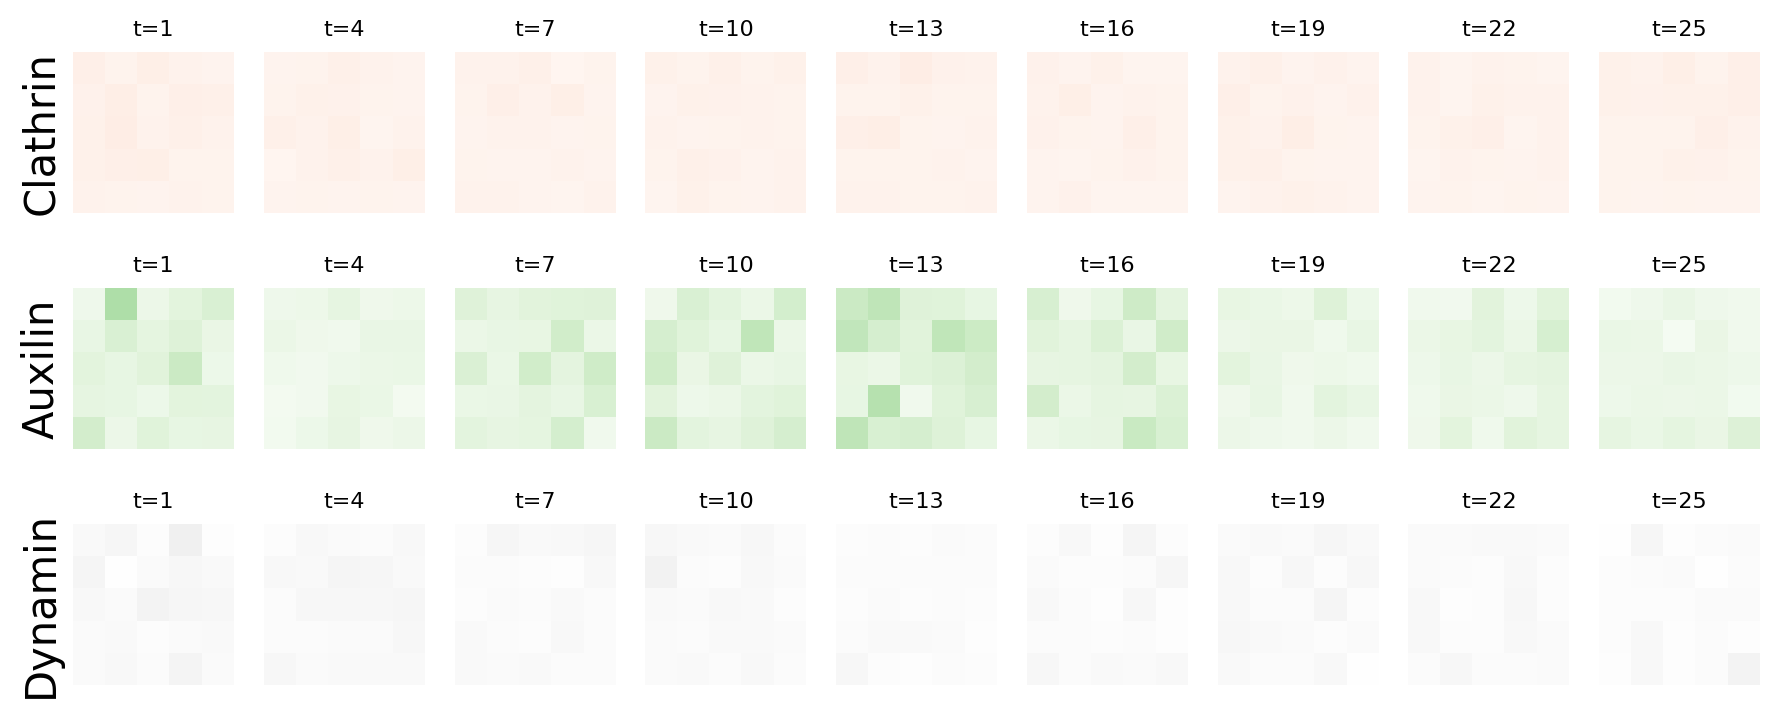

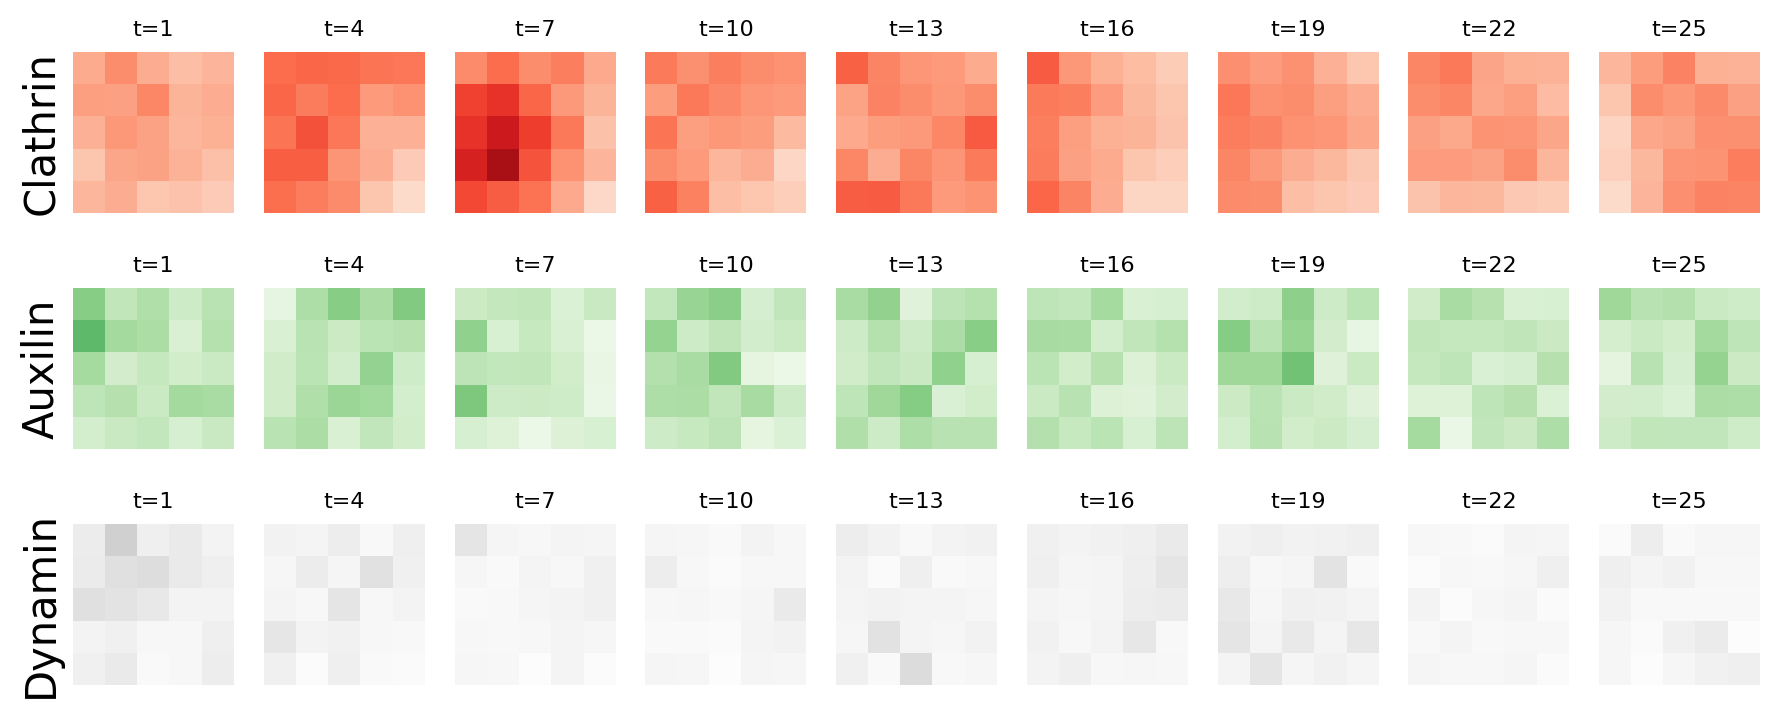

In [83]:
for ex_num, name in zip([6, 8], ['abortive', 'valid']):
    pid = d.pid.values[ex_num]
    n = len(videos[pid]['aux'])
    subsample = 3
    nsub = ceil(n / subsample)

    fig = plt.figure(figsize=(9, 4), dpi=200, facecolor='w')
    cmaps = {'cla': 'Reds', 'aux': 'Greens', 'dyn': 'Greys'}
    for k, m in enumerate(['cla', 'aux', 'dyn']):
        for j, i in enumerate(range(n)[::subsample]):
            ax = plt.subplot(3, nsub, j + 1 + nsub * k)
            ax.imshow(videos[pid][m][i], vmin=0, vmax=1, cmap=cmaps[m]) # Auxilin
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.set_title(label=f't={i + 1}', fontsize=8)
            
    plt.subplot(3, nsub, 1)
    plt.ylabel('Clathrin')
    plt.subplot(3, nsub, nsub + 1)
    plt.ylabel('Auxilin')
    plt.subplot(3, nsub, 2 * nsub + 1)
    plt.ylabel('Dynamin')
    plt.tight_layout()

    viz.savefig(f'grid_{name}')

# viz hists

In [ ]:
outcome = df[outcome_def]
R, C = 2, 1


plt.figure(figsize=(6, 12), dpi=200)
plt.subplot(R, C, 1)
# plt.title('C', loc='left', fontweight='bold')
plt.title('All events')
plt.hist(df['lifetime'][outcome == 1], label='Valid', alpha=1, color=cb, bins=25)
plt.hist(df['lifetime'][outcome == 0], label='Abortive', alpha=0.7, color=co, bins=25)
plt.xlabel('Lifetime')
plt.ylabel('Count')
plt.legend(fontsize=18, frameon=False)
plt.yscale('log')

plt.subplot(R, C, 2)
plt.hist(df['X_max'][outcome == 1], label='Valid', alpha=1, color=cb, bins=25)
plt.hist(df['X_max'][outcome == 0], label='Abortive', alpha=0.7, color=co, bins=25)
plt.xlabel('Clathrin max amplitude')
plt.ylabel('Count')
plt.yscale('log')

'''
plt.subplot(R, C, 3)
plt.hist(df['fall'][outcome == 1], label='aux+', alpha=1, color=cb, bins=25)
plt.hist(df['fall'][outcome == 0], label='aux-', alpha=0.7, color=cr, bins=25)
plt.xlabel('Fall')
plt.ylabel('Count')
'''
plt.tight_layout()
viz.savefig('hists')
# plt.savefig('figs/fig_hists.pdf')
plt.show()

# dset sizes

In [ ]:
viz.print_metadata(acc=None, metadata_file='processed/metadata_clath_aux.pkl')

In [85]:
df_test = df[df.cell_num.isin(config.SPLITS['orig']['test'])]

In [88]:
print('valid', df_test.shape[0], df_test[outcome_def].sum())

valid 2497 561.0


In [91]:
d = df_test[~df_test['short'] & ~df_test['long']]
print('difficult', d.shape[0], d[outcome_def].sum())

difficult 1045 469.0
